In [2]:
import os
import sys
os.chdir("../AnalysisCode")
from PowerIteration_Functions import *
os.chdir("../data")
from CB_02704 import *
np.random.seed(42)

In [3]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter
import pandas as pd
import seaborn as sns
from sklearn.metrics import adjusted_rand_score


In [69]:
CEU = read_geno_pop_chr('CEU',2) #northern European, USA
YRI = read_geno_pop_chr('YRI',2) ##Yoruba, Nigeria
CHB = read_geno_pop_chr('CHB',2) #Chinese, China
JPT = read_geno_pop_chr('JPT',2) #Japanese, Japan
CHD = read_geno_pop_chr('CHD',2) #Chinese, Denver
CHD_all = read_geno_pop('CHD') #northern European, USA
CHB_all = read_geno_pop('CHB') ##Yoruba, Nigeria

def GetCombinedGenoCEU_YRI_CHB(CEU, YRI, CHB, n):
    # Slice the first n columns of each array
    CEU_subset = CEU[:, :n]
    YRI_subset = YRI[:, :n]
    CHB_subset = CHB[:, :n]

    # Horizontally stack the sliced arrays
    combined = np.ma.hstack([CEU_subset, YRI_subset, CHB_subset])
    return combined

def GetCombinedGenoCHD_CHB_JPT(CHD, CHB, JPT, n):
    # Slice the first n columns of each array
    CHD_subset = CHD[:, :n]
    CHB_subset = CHB[:, :n]
    JPT_subset = JPT[:, :n]

    # Horizontally stack the sliced arrays
    combined = np.ma.hstack([CHD_subset, CHB_subset, JPT_subset])
    return combined

def GetCombinedGenoCHD_CHB(CHD, CHB, n):
    # Slice the first n columns of each array
    CHD_subset = CHD[:, :n]
    CHB_subset = CHB[:, :n]

    # Horizontally stack the sliced arrays
    combined = np.ma.hstack([CHD_subset, CHB_subset])
    return combined




In [64]:


def cluster_top_pcs(X, n_clusters, n_pcs_to_cluster, true_labels=None):
    # X: numpy array of shape (n_samples, n_pcs), data matrix with PCs as columns.
    # Limit X to the specified number of PCs if specified
    X_clustering = X[:, :n_pcs_to_cluster]
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X_clustering) # Get cluster assignments
    
    # If true_labels are provided, print the correspondence within each cluster
    # if true_labels is not None:
        # true_labels = np.array(true_labels)
        # print("Label distribution within each cluster:")
        # for i in range(n_clusters):
            # idx = np.where(cluster_labels == i)[0]
            # labels_in_cluster = true_labels[idx]
            # counts = Counter(labels_in_cluster)
            # print(f"\nCluster {i}:")
            # for label, count in counts.items():
                # print(f"  Label {label}: {count}")

                
    # Reduce data to 2D using PCA for visualization
    pca = PCA(n_components=2) # Can I do this? Might not be a good idea
    X_2d = pca.fit_transform(X_clustering)
    
    # Convert to DataFrame for Seaborn plotting
    df = pd.DataFrame(X_2d, columns=['PC1', 'PC2'])
    df['Cluster'] = cluster_labels.astype(str)  # Convert cluster labels to strings for color mapping
    
    # # Plot using Seaborn
    # plt.figure(figsize=(8, 6))
    # sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='husl', s=70, edgecolor='k', alpha=0.7)
    # plt.title(f'Clusters of Data Points using Top {n_pcs_to_cluster} PCs')
    # plt.xlabel('Principal Component 1')
    # plt.ylabel('Principal Component 2')
    # plt.legend(title='Cluster')
    # plt.grid(True)
    # plt.show()
    
    return cluster_labels



In [75]:

def get_Kmeans_of_PC(n, top10PCs, label_count):
    # Initialize lists to store the results
    results = {
        'n_pcs': [],
        'adjusted_rand_index': []
    }

    # Run clustering for different numbers of PCs and collect metrics
    for pc in range(2, 11):
        # print(f"\nClustering using top {pc} PCs:")
        # Perform clustering and plot
        cluster_labels = cluster_top_pcs(top10PCs, n_clusters=n, n_pcs_to_cluster=pc, true_labels=[0]*label_count + 
                                         [1]*label_count + [2]*label_count)
        
        # Calculate Adjusted Rand Index
        if n == 3:
            ari = adjusted_rand_score([0]*label_count + [1]*label_count + [2]*label_count, cluster_labels)
        elif n == 2:
            ari = adjusted_rand_score([0]*label_count + [1]*label_count, cluster_labels)
            
        # print(f"Adjusted Rand Index for {pc} PCs: {ari:.4f}")
        
        # Store results
        results['n_pcs'].append(pc)
        results['adjusted_rand_index'].append(ari)

    return results



In [66]:

# Convert results to a DataFrame for easy manipulation
def plot_results(results, title):

    results_df = pd.DataFrame(results)

    # # Display the summary table
    # print("\nSummary Table:")
    # print(results_df)

    # Plot Adjusted Rand Index vs. Number of PCs
    plt.figure(figsize=(5, 3))
    sns.lineplot(data=results_df, x='n_pcs', y='adjusted_rand_index', marker='o', color='black')
    plt.title("Clustering Performance for "+title)
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Adjusted Rand Index")
    plt.grid(True)
    plt.show()

    results_df["adjusted_rand_index"].values



Power iteration: converged at iter=40
Power iteration: converged at iter=1
Power iteration: converged at iter=346
Power iteration: converged at iter=257
Power iteration: converged at iter=330
Power iteration: converged at iter=113
Power iteration: converged at iter=647
Power iteration: converged at iter=448
Power iteration: converged at iter=1
Power iteration: converged at iter=3036
Power iteration: converged at iter=34
Power iteration: converged at iter=1
Power iteration: converged at iter=728
Power iteration: converged at iter=1641
Power iteration: converged at iter=2
Power iteration: converged at iter=74
Power iteration: converged at iter=1316
Power iteration: converged at iter=1
Power iteration: converged at iter=569
Power iteration: converged at iter=1354
Power iteration: converged at iter=34
Power iteration: converged at iter=1
Power iteration: converged at iter=857
Power iteration: converged at iter=1
Power iteration: converged at iter=389
Power iteration: converged at iter=599


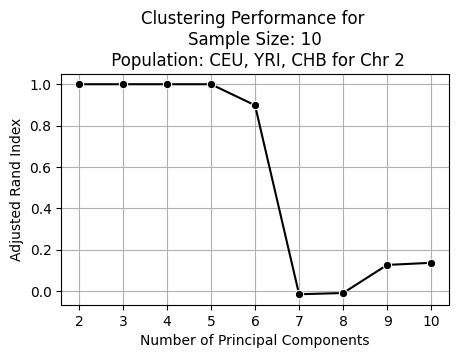

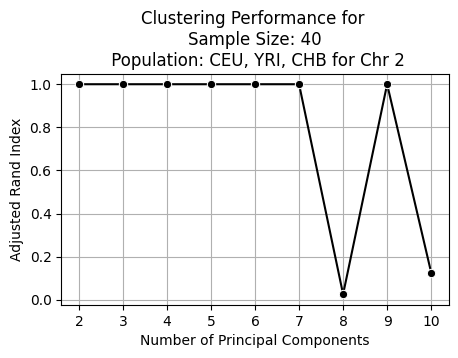

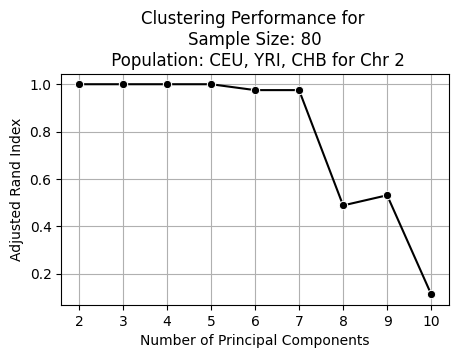

In [76]:

'''Get the top 10 PCs and run KMeans clustering for 3 clusters for different sample sizes'''

clusters = 3
label_count = 10
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCEU_YRI_CHB(CEU, YRI, CHB, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_10 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 40
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCEU_YRI_CHB(CEU, YRI, CHB, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_40 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 80
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCEU_YRI_CHB(CEU, YRI, CHB, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_80 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

plot_results(results_10, "\nSample Size: 10\n Population: CEU, YRI, CHB for Chr 2")
plot_results(results_40, "\nSample Size: 40\n Population: CEU, YRI, CHB for Chr 2")
plot_results(results_80, "\nSample Size: 80\n Population: CEU, YRI, CHB for Chr 2")



Power iteration: converged at iter=356
Power iteration: converged at iter=2
Power iteration: converged at iter=309
Power iteration: converged at iter=3265
Power iteration: converged at iter=2
Power iteration: converged at iter=1003
Power iteration: converged at iter=1
Power iteration: converged at iter=2790
Power iteration: converged at iter=1
Power iteration: converged at iter=1104
Power iteration: converged at iter=89
Power iteration: converged at iter=73
Power iteration: converged at iter=768
Power iteration: converged at iter=303
Power iteration: converged at iter=2
Power iteration: converged at iter=505
Power iteration: converged at iter=1177
Power iteration: converged at iter=2
Power iteration: converged at iter=932
Power iteration: converged at iter=2
Power iteration: converged at iter=39
Power iteration: converged at iter=400
Power iteration: converged at iter=514
Power iteration: converged at iter=1
Power iteration: converged at iter=1347
Power iteration: converged at iter=1
P

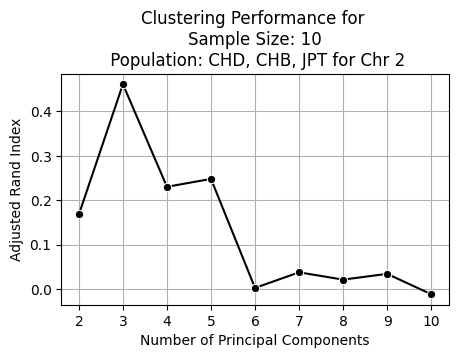

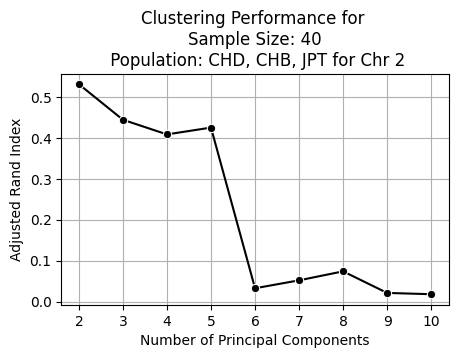

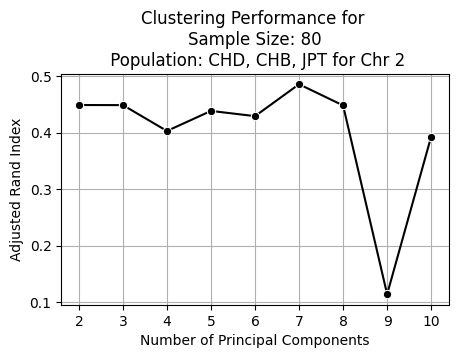

In [77]:

'''Get the top 10 PCs and run KMeans clustering for 3 clusters for different sample sizes and pops: CHD, CHB, JPT'''

clusters = 3
label_count = 10
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB_JPT(CHD, CHB, JPT, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_10 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 40
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB_JPT(CHD, CHB, JPT, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_40 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 80
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB_JPT(CHD, CHB, JPT, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_80 = get_Kmeans_of_PC(clusters, top10PCs, label_count)


plot_results(results_10, "\nSample Size: 10\n Population: CHD, CHB, JPT for Chr 2")
plot_results(results_40, "\nSample Size: 40\n Population: CHD, CHB, JPT for Chr 2")
plot_results(results_80, "\nSample Size: 80\n Population: CHD, CHB, JPT for Chr 2")


Power iteration: converged at iter=581
Power iteration: converged at iter=450
Power iteration: converged at iter=2
Power iteration: converged at iter=229
Power iteration: converged at iter=1229
Power iteration: converged at iter=2
Power iteration: converged at iter=725
Power iteration: converged at iter=177
Power iteration: converged at iter=1096
Power iteration: converged at iter=1
(10, 20)
Power iteration: converged at iter=96
Power iteration: converged at iter=721
Power iteration: converged at iter=289
Power iteration: converged at iter=2
Power iteration: converged at iter=403
Power iteration: converged at iter=6508
Power iteration: converged at iter=2
Power iteration: converged at iter=818
Power iteration: converged at iter=2
Power iteration: converged at iter=1318
Power iteration: converged at iter=229
Power iteration: converged at iter=137
Power iteration: converged at iter=1536
Power iteration: converged at iter=2
Power iteration: converged at iter=477
Power iteration: converged

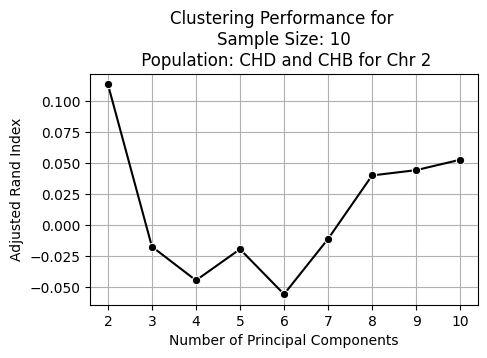

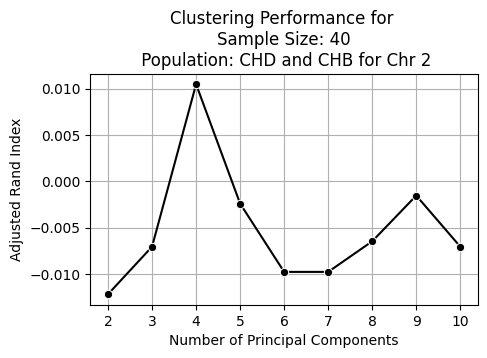

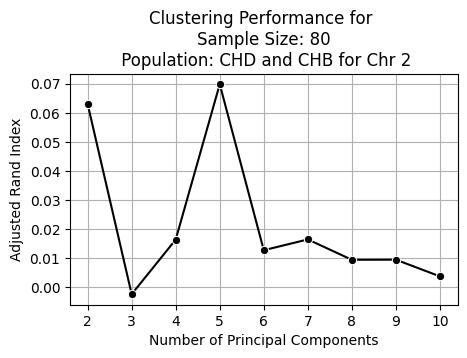

In [78]:

'''Get the top 10 PCs and run KMeans clustering for 3 clusters for different sample sizes and pops: CHD, CHB for Chr 2'''

clusters = 2
label_count = 10
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB(CHD, CHB, label_count))
print(np.array(top10PCs).shape)
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_10 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 40
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB(CHD, CHB, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_40 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 80
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB(CHD, CHB, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_80 = get_Kmeans_of_PC(clusters, top10PCs, label_count)


plot_results(results_10, "\nSample Size: 10\n Population: CHD and CHB for Chr 2")
plot_results(results_40, "\nSample Size: 40\n Population: CHD and CHB for Chr 2")
plot_results(results_80, "\nSample Size: 80\n Population: CHD and CHB for Chr 2")


Power iteration: converged at iter=1280
Power iteration: converged at iter=1
Power iteration: converged at iter=1222
Power iteration: converged at iter=1174
Power iteration: converged at iter=1095
Power iteration: converged at iter=725
Power iteration: converged at iter=1
Power iteration: converged at iter=7464
Power iteration: converged at iter=1
Power iteration: converged at iter=23307
Power iteration: converged at iter=83
Power iteration: converged at iter=221
Power iteration: converged at iter=1
Power iteration: converged at iter=2286
Power iteration: converged at iter=2309
Power iteration: converged at iter=2
Power iteration: converged at iter=5265
Power iteration: converged at iter=2542
Power iteration: converged at iter=2
Power iteration: converged at iter=960
Power iteration: converged at iter=163
Power iteration: converged at iter=1
Power iteration: converged at iter=75
Power iteration: converged at iter=1916
Power iteration: converged at iter=16242
Power iteration: converged 

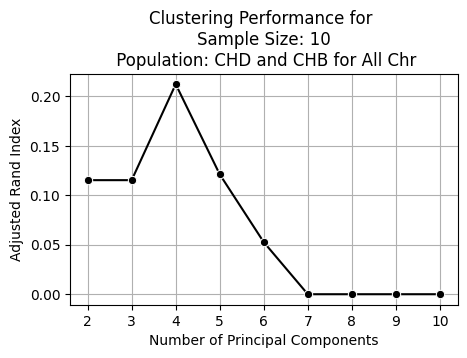

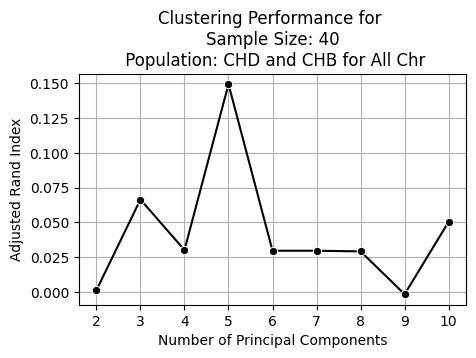

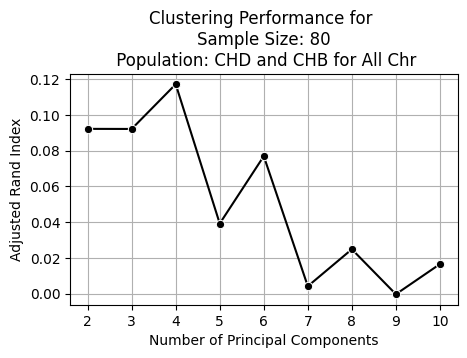

In [79]:

'''Get the top 10 PCs and run KMeans clustering for 3 clusters for different sample sizes and pops: CHD, CHB for All Chr'''

clusters = 2
label_count = 10
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB(CHD_all, CHB_all, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_10 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 40
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB(CHD_all, CHB_all, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_40 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 80
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB(CHD_all, CHB_all, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_80 = get_Kmeans_of_PC(clusters, top10PCs, label_count)


plot_results(results_10, "\nSample Size: 10\n Population: CHD and CHB for All Chr")
plot_results(results_40, "\nSample Size: 40\n Population: CHD and CHB for All Chr")
plot_results(results_80, "\nSample Size: 80\n Population: CHD and CHB for All Chr")
